In [3]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
    
    
    
# для ML: XGB
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper    
    

Populating the interactive namespace from numpy and matplotlib


In [2]:
#загружаем  данные
train = pd.read_csv('e:/DS/data/rossmann-store-sales/train.csv',  sep=',', index_col=['Date'], parse_dates=['Date'], dayfirst=True)
test = pd.read_csv('e:/DS/data/rossmann-store-sales/test.csv',  sep=',', index_col=['Date'], parse_dates=['Date'], dayfirst=True)

store = pd.read_csv('e:/DS/data/rossmann-store-sales/store.csv',  sep=',')


E:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
test.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,1,1,4,1.0,1,0,0
2015-09-17,2,3,4,1.0,1,0,0
2015-09-17,3,7,4,1.0,1,0,0
2015-09-17,4,8,4,1.0,1,0,0
2015-09-17,5,9,4,1.0,1,0,0


In [4]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [5]:

train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

#Добавим новые переменные, которые будут нужны для ML моделей 
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

In [6]:
print("Всего в train: ", train.shape)
print("Всего в tets: ", test.shape)

Всего в train:  (1017209, 13)
Всего в tets:  (41088, 7)


In [7]:
# Есть ли закрытые магазины
train[(train.Open == 0) & (train.Sales == 0)].head()


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


In [8]:
#Удалим закрытые магазины
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]
test =  test[test["Open"] != 0]

print("Всего в train: ", train.shape)
print("Всего в tets: ", test.shape)


Всего в train:  (844338, 13)
Всего в tets:  (35104, 7)


In [9]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118


In [10]:
train['Sales'].min(), train['Sales'].max()

(46, 41551)

In [11]:
train[(train.index >='2013-01-07') &  (train.index <='2013-01-13') ]['Sales'].mean()

7410.922243946458

In [12]:
#Сделаем группировку по неделяем 

In [13]:
train_weekly = train.resample('W', how='mean')
train_weekly.head()

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  """Entry point for launching an IPython kernel.


,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,
2013-01-06,557.926415,4.499665,5844.181391,695.728472,1.0,0.000000,0.740103,2013.0,1.000000,3.499665,1.0,8.813720
2013-01-13,558.500226,3.509099,7410.922244,786.035494,1.0,0.831102,0.083471,2013.0,1.000000,9.509099,2.0,9.787386
2013-01-20,558.551931,3.511048,5167.257628,632.157373,1.0,0.000000,0.000000,2013.0,1.000000,16.511048,3.0,8.598862
2013-01-27,558.658613,3.511104,6908.788866,739.620798,1.0,0.830732,0.000000,2013.0,1.000000,23.511104,4.0,9.764981
2013-02-03,558.165041,3.511178,5771.347187,676.316579,1.0,0.000000,0.019205,2013.0,1.335634,20.106527,5.0,8.955165


In [14]:
train_weekly.shape

(135, 12)

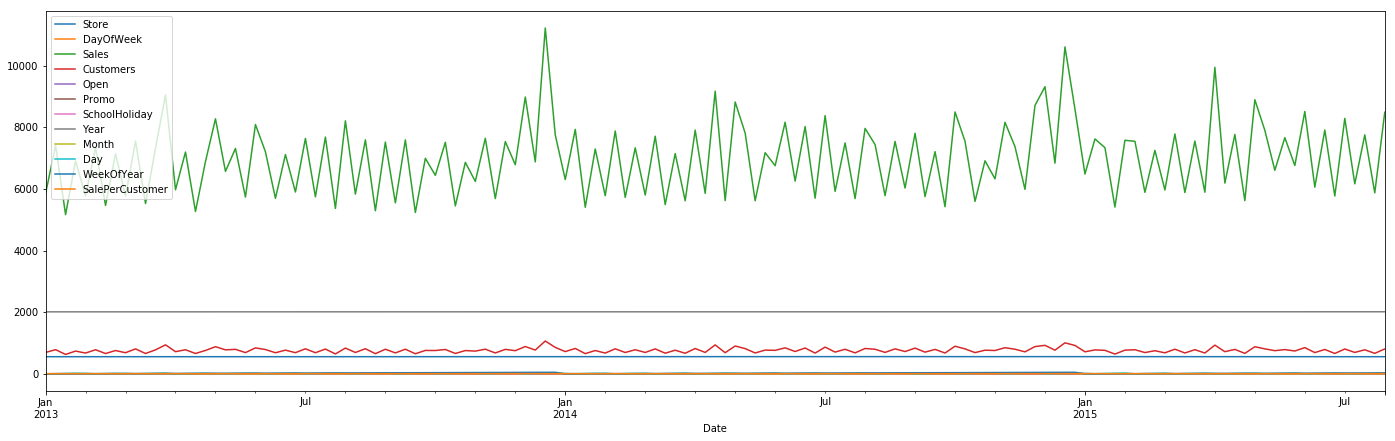

In [15]:
train_weekly.plot(figsize=(24,7))

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

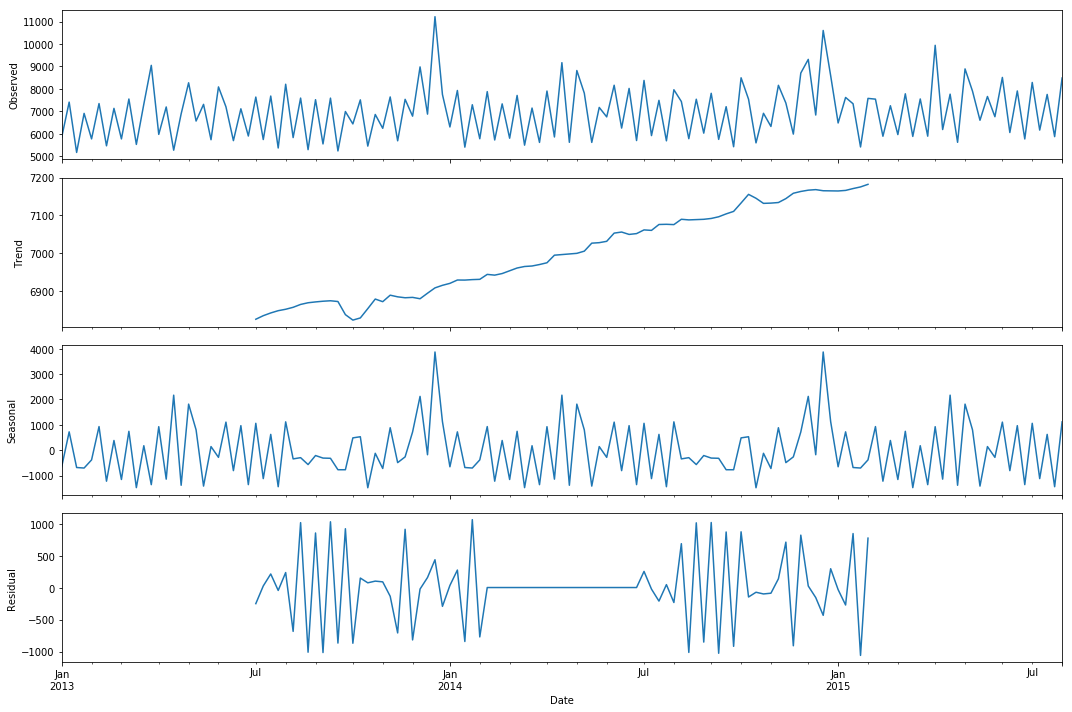

In [16]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(train_weekly.Sales).plot() #, model='additive'
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_weekly.Sales)[1])

In [17]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(30).mean()
    #rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(30).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

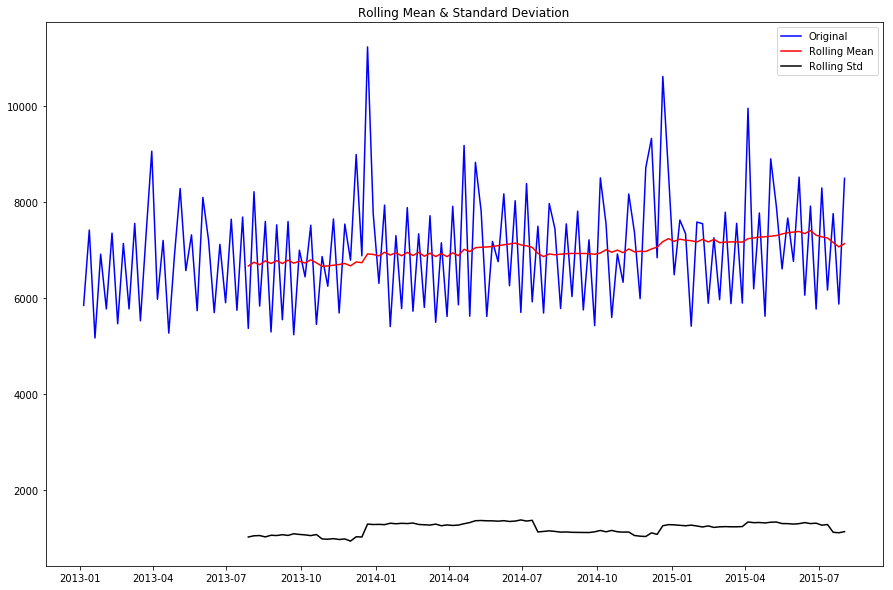

Results of Dickey-Fuller Test:
Test Statistic                -6.725479e+00
p-value                        3.398316e-09
#Lags Used                     1.000000e+00
Number of Observations Used    1.330000e+02
Critical Value (1%)           -3.480500e+00
Critical Value (5%)           -2.883528e+00
Critical Value (10%)          -2.578496e+00
dtype: float64


In [36]:
test_stationarity(train_weekly.Sales)

## Подготовим данные магазинов

In [18]:
#Проверим пустые значения
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [19]:
# пустые значения в  CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [20]:
# CompetitionDistance заполним средним значением
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [21]:
#отсутствие акций
_ = store[pd.isnull(store.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)

In [22]:
# пустые значения заполним нулем
store.fillna(0, inplace = True)

In [23]:
print("Объединим данные о продажах и магазинах.")

train_store = pd.merge(train, store, how = 'inner', on = 'Store')
print("Всего : ", train_store.shape)
train_store.head()

Объединим данные о продажах и магазинах.
Всего :  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


Посмотрим данные по типам магазинов 

In [24]:

train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [25]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


## 1. Анализ данных статическими моделями типа ARIMA

### Посмотрим данные по разным типам магазинов 
Возьмем по одному магазину в каждом типе
Тип А берем магазин 3.

In [27]:
#train_store[train_store.StoreType== 'a'].groupby('Store')['Customers', 'Sales'].sum()

Посмотрим распределение данных в магазинах разных типов, их тренды

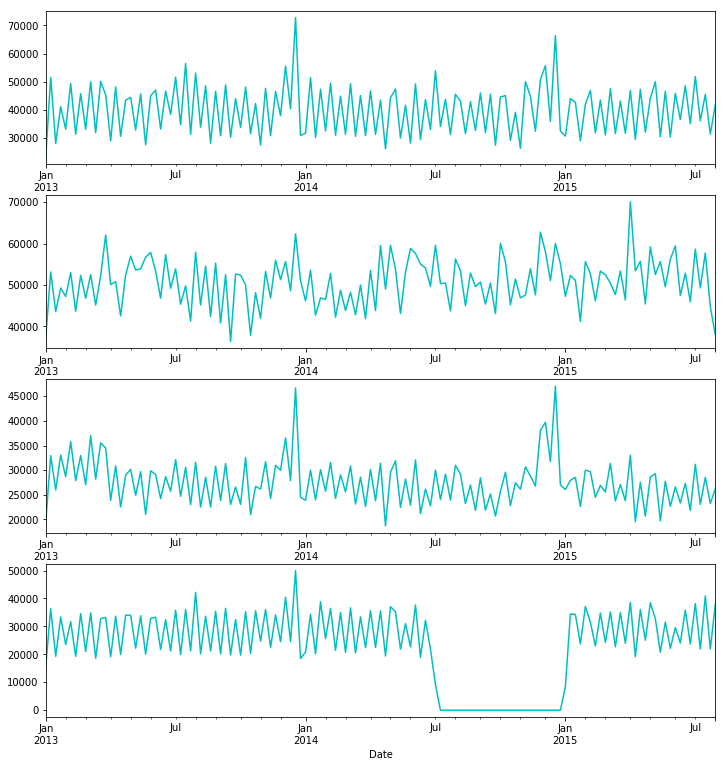

In [45]:
# 
train['Sales'] = train['Sales'] * 1.0

# store types
sales_a = train[train.Store == 3]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a.resample('W').sum().plot(color = 'c', ax = ax1)
sales_b.resample('W').sum().plot(color = 'c', ax = ax2)
sales_c.resample('W').sum().plot(color = 'c', ax = ax3)
sales_d.resample('W').sum().plot(color = 'c', ax = ax4)

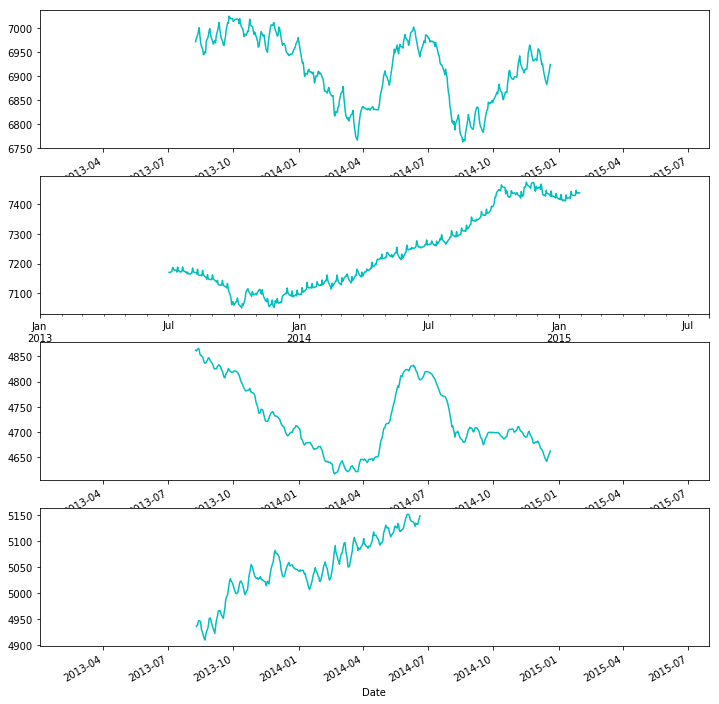

In [46]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# monthly
decomposition_a = sm.tsa.seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot(color = 'c', ax = ax1)

decomposition_b = sm.tsa.seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot(color = 'c', ax = ax2)

decomposition_c = sm.tsa.seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot(color = 'c', ax = ax3)

decomposition_d = sm.tsa.seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot(color = 'c', ax = ax4)

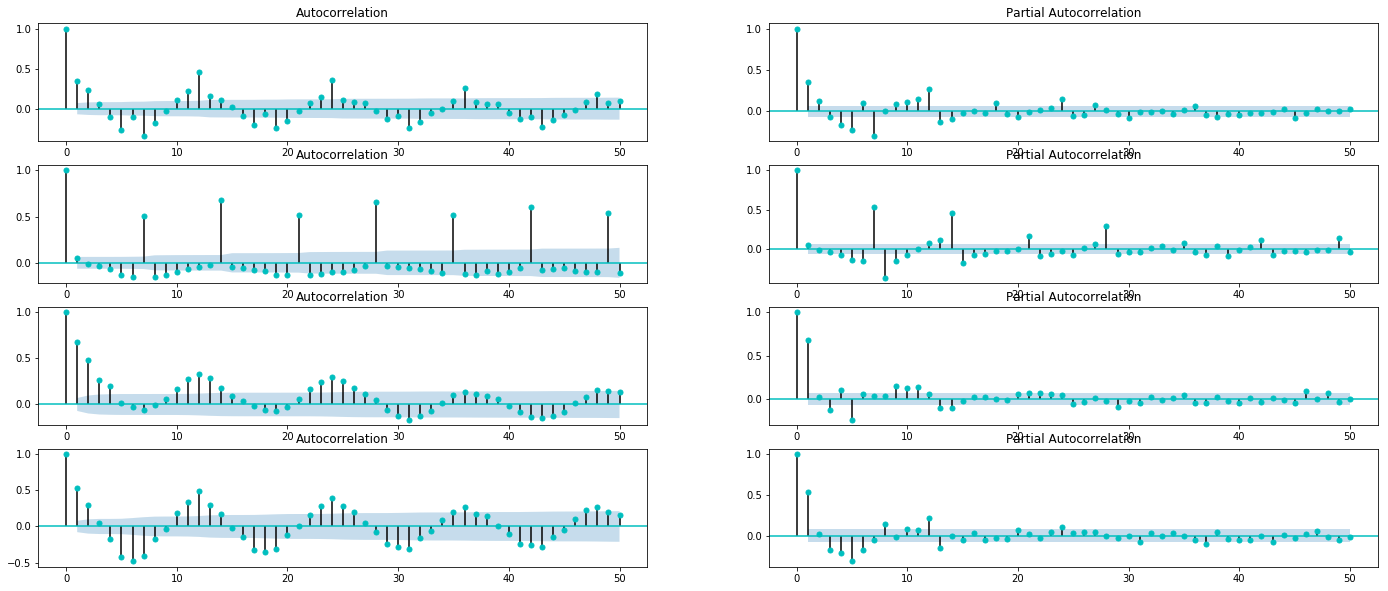

In [47]:
### Выводы
# figure for subplots
plt.figure(figsize = (24, 10))

# acf and pacf for A
plt.subplot(421); sm.graphics.tsa.plot_acf(sales_a, lags = 50, ax = plt.gca(), color = 'c')
plt.subplot(422); sm.graphics.tsa.plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = 'c')

# acf and pacf for B
plt.subplot(423); sm.graphics.tsa.plot_acf(sales_b, lags = 50, ax = plt.gca(), color = 'c')
plt.subplot(424); sm.graphics.tsa.plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = 'c')

# acf and pacf for C
plt.subplot(425); sm.graphics.tsa.plot_acf(sales_c, lags = 50, ax = plt.gca(), color = 'c')
plt.subplot(426); sm.graphics.tsa.plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = 'c')

# acf and pacf for D
plt.subplot(427); sm.graphics.tsa.plot_acf(sales_d, lags = 50, ax = plt.gca(), color = 'c')
plt.subplot(428); sm.graphics.tsa.plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = 'c')

plt.show()

In [48]:
sales_a=sales_a.to_frame()
sales_a.head()

,Sales
Date,
2015-07-31,8314.0
2015-07-30,8977.0
2015-07-29,7610.0
2015-07-28,8864.0
2015-07-27,8107.0


Оптимальный параметр преобразования Бокса-Кокса: 0.091277
Критерий Дики-Фуллера: p=0.000000


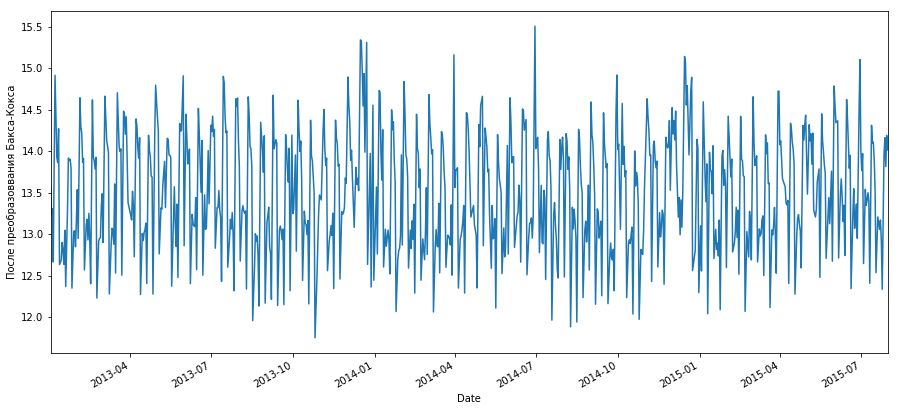

In [49]:
sales_a['Sales'], lmbda = stats.boxcox(sales_a['Sales'])
plt.figure(figsize(15,7))
sales_a['Sales'].plot()
plt.ylabel(u'После преобразоввания Бакса-Кокса')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sales_a['Sales'])[1])

Критерий Дики-Фуллера отвергает гипотезу о нестационарности ряда

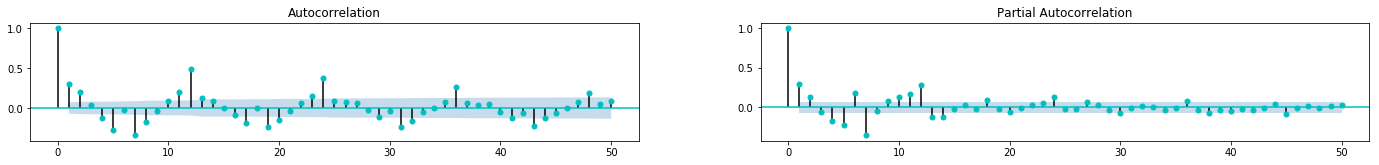

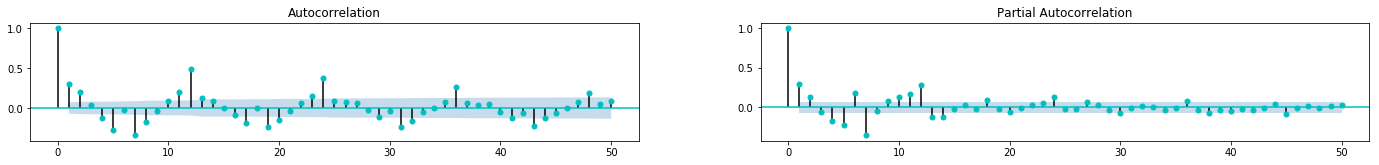

In [50]:
### Возьмет для модели магазин типа А
## Подбираем параметры для модели
plt.figure(figsize = (24, 10))

# acf and pacf for A
plt.subplot(421); sm.graphics.tsa.plot_acf(sales_a, lags = 50, ax = plt.gca(), color = 'c')
plt.subplot(422); sm.graphics.tsa.plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = 'c')

Начальные приближения Q = 1, q= 1, P=1, p=1

In [51]:
ps = range(0, 2)
d=1
qs = range(0,1)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [52]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [55]:
results=[]
def run():
    
    best_aic = float("inf")
    warnings.filterwarnings('ignore')

    for param in parameters_list:
        print(param)
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
           
            model=sm.tsa.statespace.SARIMAX(sales_a.Sales, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except ValueError:
            print('wrong parameters:', param)
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    
    warnings.filterwarnings('default')
    return results, best_model, best_param, best_aic

In [56]:
res =  run()
print(res)

(0, 0, 0, 0)
(0, 0, 0, 1)
(0, 0, 1, 0)
(0, 0, 1, 1)
(1, 0, 0, 0)
(1, 0, 0, 1)
(1, 0, 1, 0)
(1, 0, 1, 1)
([[(0, 0, 0, 0), 1943.3522819371965], [(0, 0, 0, 1), 1736.0809277778405], [(0, 0, 1, 0), 1810.463730411358], [(0, 0, 1, 1), 1717.698980029865], [(1, 0, 0, 0), 1747.5893832414463], [(1, 0, 0, 1), 1563.3761481991692], [(1, 0, 1, 0), 1625.8613028577702], [(1, 0, 1, 1), 1536.784259779015]], <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x0000000014A4B518>, (1, 0, 1, 1), 1536.784259779015)


In [57]:
results = res[0]
best_model = res[1]
best_param = res[2]
best_aic  = res[3]

In [58]:
print(results)

[[(0, 0, 0, 0), 1943.3522819371965], [(0, 0, 0, 1), 1736.0809277778405], [(0, 0, 1, 0), 1810.463730411358], [(0, 0, 1, 1), 1717.698980029865], [(1, 0, 0, 0), 1747.5893832414463], [(1, 0, 0, 1), 1563.3761481991692], [(1, 0, 1, 0), 1625.8613028577702], [(1, 0, 1, 1), 1536.784259779015]]


In [59]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  779
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -764.392
Date:                            Mon, 17 Jun 2019   AIC                           1536.784
Time:                                    10:51:07   BIC                           1555.349
Sample:                                         0   HQIC                          1543.931
                                            - 779                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4632      0.027    -17.021      0.000      -0.516      -0.410
ar.S.L12       0.3399      0.038   

Критерий Стьюдента: p=0.903093


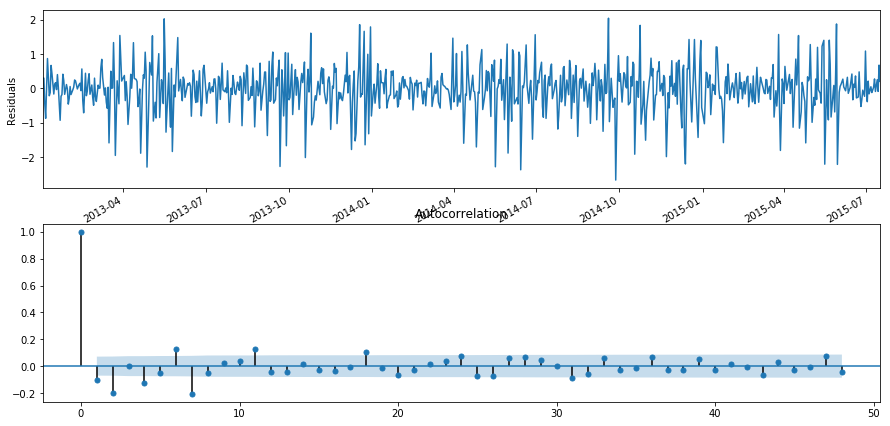

In [60]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])

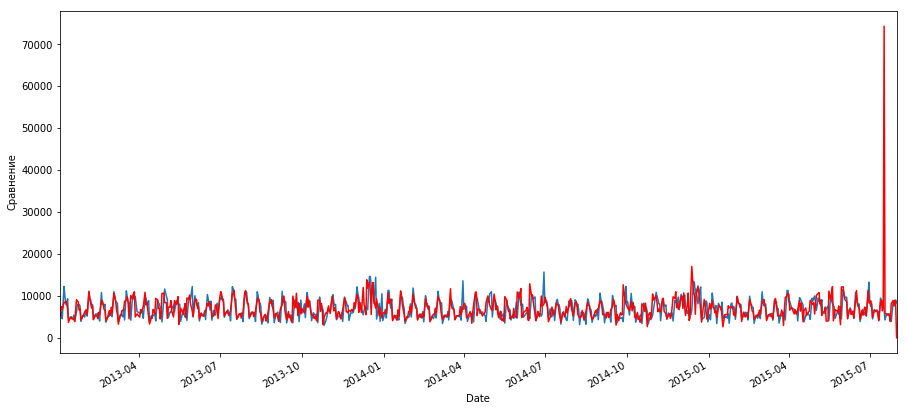

In [61]:
sales_a['model'] = invboxcox(best_model.fittedvalues, lmbda)
sales_a['Sales'] = invboxcox(sales_a['Sales'], lmbda)
plt.figure(figsize(15,7))
sales_a.Sales.plot()
sales_a.model.plot(color='r')
plt.ylabel('Сравнение')
pylab.show()

Модель хорошо приближает данные, за исключением выброса

### Прогнозирование

In [63]:
test_a = test[test.Store ==3]
test_a.tail()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-08-06,35954,3,4,1.0,1,0,1
2015-08-05,36810,3,3,1.0,1,0,1
2015-08-04,37666,3,2,1.0,1,0,1
2015-08-03,38522,3,1,1.0,1,0,1
2015-08-01,40234,3,6,1.0,0,0,0


In [64]:
y = sales_a.sort_values('Date', ascending = True)
test_a = test_a.sort_values('Date', ascending = True)
future = pd.DataFrame(index=test_a.index, columns= sales_a.columns)
y = pd.concat([y, future])
y.shape, sales_a.shape, test_a.shape

((820, 2), (779, 2), (41, 7))

In [65]:
#y.iloc[1]
#y.index[779], y.index[809]
#y.info()
#best_model.nobs

In [66]:
## "танец с бубном" для преобразования прогнозных данных, потому что
# best_model.predict(start='date1', end='date2') так и не сработал у меня
tt= invboxcox(best_model.predict(start=779, end=826), lmbda)    
tt = tt.to_frame()
tt.index = tt.index -779
tt['Date'] = '2015-08-01 00:00:00'
tt['Date'] = pd.to_datetime(tt['Date'])
tt['Date'] = pd.to_datetime(tt.Date) + pd.to_timedelta(pd.np.ceil(tt.index), unit="D")
tt = tt.reset_index()
tt= tt.set_index('Date')
tt =tt.drop(columns=['index'])




E:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [67]:
#y = sales_a.sort_values('Date', ascending = True)
#test_a = test_a.sort_values('Date', ascending = True)
##date_list = [datetime.datetime.strptime("2015-08-01", "%Y-%m-%d") + relativedelta(day=x) for x in range(1,32)]
#date_list
#future = pd.DataFrame(index=date_list, columns= sales_a.columns)
#y = pd.concat([y, future])
#y['forecast'] =  invboxcox(best_model.predict(start=779, end=809), lmbda)

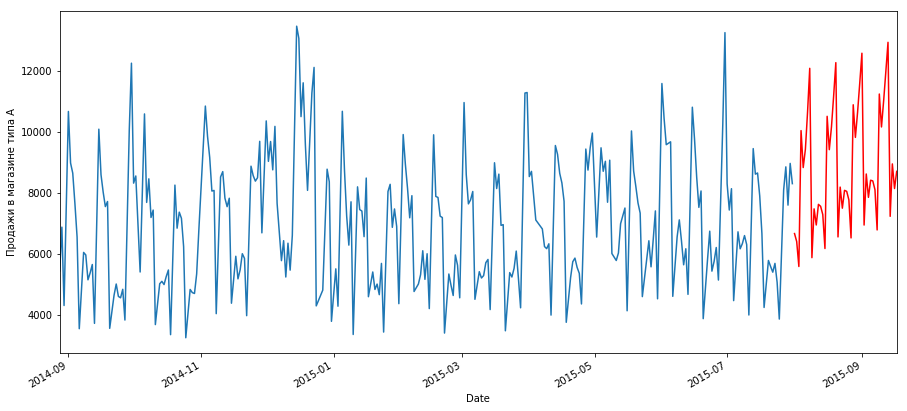

In [68]:

plt.figure(figsize(15,7))
y.iloc[500:779].Sales.plot()
tt[0].plot(color='r')# прогноз
plt.ylabel('Продажи в магазине типа А')
pylab.show()



## 2. XGBoost

In [26]:
#данные
test = pd.read_csv('e:/DS/data/rossmann-store-sales/test.csv',  sep=',', index_col=['Date'], parse_dates=['Date'], dayfirst=True)



In [27]:
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [28]:
test[pd.isnull(test.Open)]

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,480,622,4,NaN,1,0,0
2015-09-16,1336,622,3,NaN,1,0,0
2015-09-15,2192,622,2,NaN,1,0,0
2015-09-14,3048,622,1,NaN,1,0,0
2015-09-12,4760,622,6,NaN,0,0,0
2015-09-11,5616,622,5,NaN,0,0,0
2015-09-10,6472,622,4,NaN,0,0,0
2015-09-09,7328,622,3,NaN,0,0,0
2015-09-08,8184,622,2,NaN,0,0,0


In [29]:
test.fillna(1, inplace = True)

Encoding данных 

In [34]:
# data extraction
test['Year'] = test.index.year
test['Month'] = test.index.month
test['Day'] = test.index.day
test['WeekOfYear'] = test.index.weekofyear

# to numerical
mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
test.StateHoliday.replace(mappings, inplace = True)

train_store.Assortment.replace(mappings, inplace = True)
train_store.StoreType.replace(mappings, inplace = True)
train_store.StateHoliday.replace(mappings, inplace = True)
train_store.drop('PromoInterval', axis = 1, inplace = True)



store.StoreType.replace(mappings, inplace = True)
store.Assortment.replace(mappings, inplace = True)
store.drop('PromoInterval', axis = 1, inplace = True)


In [35]:
train_store.Assortment = train_store.Assortment.astype(str).astype(int)
train_store.StateHoliday  = train_store.StateHoliday.astype(str).astype(int)

In [37]:
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,WeekOfYear,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
0,1,5,5263,555,1,1,0,1,2015,7,...,31,9.482883,3,1,1270.0,9.0,2008.0,0,0.0,0.0
1,1,4,5020,546,1,1,0,1,2015,7,...,31,9.194139,3,1,1270.0,9.0,2008.0,0,0.0,0.0
2,1,3,4782,523,1,1,0,1,2015,7,...,31,9.143403,3,1,1270.0,9.0,2008.0,0,0.0,0.0
3,1,2,5011,560,1,1,0,1,2015,7,...,31,8.948214,3,1,1270.0,9.0,2008.0,0,0.0,0.0
4,1,1,6102,612,1,1,0,1,2015,7,...,31,9.970588,3,1,1270.0,9.0,2008.0,0,0.0,0.0


In [58]:
test

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41088 entries, 2015-09-17 to 2015-08-01
Data columns (total 11 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Open             41088 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
Year             41088 non-null int64
Month            41088 non-null int64
Day              41088 non-null int64
WeekOfYear       41088 non-null int64
dtypes: float64(1), int64(9), object(1)
memory usage: 5.0+ MB


In [38]:
print("Объединим данные продаж и информацию о магазинах.")
test_store = pd.merge(test, store, how = 'inner', on = 'Store')

test_store['CompetitionOpen'] = 12 * (test_store.Year - test_store.CompetitionOpenSinceYear) + (test_store.Month - test_store.CompetitionOpenSinceMonth)
test_store['PromoOpen'] = 12 * (test_store.Year - test_store.Promo2SinceYear) + (test_store.WeekOfYear - test_store.Promo2SinceWeek) / 4.0

print("In total: ", test_store.shape)
test_store.head()

Объединим данные продаж и информацию о магазинах.
In total:  (41088, 21)


,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen
0,1,1,4,1.0,1,0,0,2015,9,17,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
1,857,1,3,1.0,1,0,0,2015,9,16,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
2,1713,1,2,1.0,1,0,0,2015,9,15,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
3,2569,1,1,1.0,1,0,0,2015,9,14,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
4,3425,1,7,0.0,0,0,0,2015,9,13,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.25


In [39]:
test_store.Assortment = test_store.Assortment.astype(str).astype(int)
test_store.StateHoliday  = test_store.StateHoliday.astype(str).astype(int)

In [40]:
# split into training and evaluation sets
# excluding Sales and Id columns
predictors = [x for x in train_store.columns if x not in ['Customers', 'Sales', 'SalePerCustomer']]
y = np.log(train_store.Sales) # log transformation of Sales
X = train_store

# split the data into train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, # 30% for the evaluation set
                                                    random_state = 42)

In [41]:
# predictors
X.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'SalePerCustomer', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear'],
      dtype='object')

In [92]:
# base parameters
params = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', # regression task
    'subsample': 0.8, # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.85, # 85% of features used
    'eta': 0.1, 
    'max_depth': 10, 
    'seed': 42} # for reproducible results

In [63]:

train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 21 columns):
Store                        844338 non-null int64
DayOfWeek                    844338 non-null int64
Sales                        844338 non-null int64
Customers                    844338 non-null int64
Open                         844338 non-null int64
Promo                        844338 non-null int64
StateHoliday                 844338 non-null int32
SchoolHoliday                844338 non-null int64
Year                         844338 non-null int64
Month                        844338 non-null int64
Day                          844338 non-null int64
WeekOfYear                   844338 non-null int64
SalePerCustomer              844338 non-null float64
StoreType                    844338 non-null int64
Assortment                   844338 non-null int32
CompetitionDistance          844338 non-null float64
CompetitionOpenSinceMonth    844338 non-null float64
CompetitionOpenS

In [17]:
# evaluation metric: rmspe
# Root Mean Square Percentage Error
# code chunk shared at Kaggle

def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat / y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

#Добавим метрику RMSLE
from sklearn.metrics.scorer import make_scorer
custom_scorer = make_scorer(rmspe, greater_is_better=True)

In [64]:
# XGB with xgboost library
dtrain = xgb.DMatrix(X_train[predictors], y_train)
dtest = xgb.DMatrix(X_test[predictors], y_test)

watchlist = [(dtrain, 'train'), (dtest, 'test')]

xgb_model = xgb.train(params, dtrain, 300, evals = watchlist,
                      early_stopping_rounds = 50, feval = rmspe_xg, verbose_eval = True)

[12:12:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[0]	train-rmse:7.44335	test-rmse:7.44302	train-rmspe:0.999527	test-rmspe:0.999527
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 50 rounds.
[12:12:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[1]	train-rmse:6.70071	test-rmse:6.70037	train-rmspe:0.998824	test-rmspe:0.998824
[12:12:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[2]	train-rmse:6.03252	test-rmse:6.03214	train-rmspe:0.997553	test-rmspe:0.997553
[12:12:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[3]	train-rmse:5.43121	test-rmse:5.43082	train-rmspe:0.995413	test-rmspe:0.995415
[12:12:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256

[12:12:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1288 extra nodes, 0 pruned nodes, max_depth=10
[41]	train-rmse:0.244019	test-rmse:0.244719	train-rmspe:0.263366	test-rmspe:0.231622
[12:12:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1050 extra nodes, 0 pruned nodes, max_depth=10
[42]	train-rmse:0.238108	test-rmse:0.238918	train-rmspe:0.261652	test-rmspe:0.229156
[12:12:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1806 extra nodes, 0 pruned nodes, max_depth=10
[43]	train-rmse:0.233137	test-rmse:0.234068	train-rmspe:0.260483	test-rmspe:0.227351
[12:12:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1444 extra nodes, 0 pruned nodes, max_depth=10
[44]	train-rmse:0.229635	test-rmse:0.230612	train-rmspe:0.260039	test-rmspe:0.226598
[12:12:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1012 extra nodes, 0 pruned nodes, max_depth=10
[45]	train-rmse:0.223515	test-rmse:0.224533	train-rmspe:0.257821	test-rmspe:0.222843


[12:12:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1412 extra nodes, 0 pruned nodes, max_depth=10
[83]	train-rmse:0.161925	test-rmse:0.16427	train-rmspe:0.20712	test-rmspe:0.179241
[12:12:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1234 extra nodes, 0 pruned nodes, max_depth=10
[84]	train-rmse:0.159955	test-rmse:0.162327	train-rmspe:0.205363	test-rmspe:0.177163
[12:12:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1274 extra nodes, 0 pruned nodes, max_depth=10
[85]	train-rmse:0.159066	test-rmse:0.161458	train-rmspe:0.204649	test-rmspe:0.176284
[12:12:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1558 extra nodes, 0 pruned nodes, max_depth=10
[86]	train-rmse:0.157791	test-rmse:0.160204	train-rmspe:0.203537	test-rmspe:0.175003
[12:12:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1824 extra nodes, 0 pruned nodes, max_depth=10
[87]	train-rmse:0.156676	test-rmse:0.159113	train-rmspe:0.202452	test-rmspe:0.173706
[1

[12:13:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1670 extra nodes, 0 pruned nodes, max_depth=10
[124]	train-rmse:0.132409	test-rmse:0.135934	train-rmspe:0.162836	test-rmspe:0.148739
[12:13:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1244 extra nodes, 0 pruned nodes, max_depth=10
[125]	train-rmse:0.132275	test-rmse:0.135825	train-rmspe:0.162705	test-rmspe:0.148626
[12:13:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1522 extra nodes, 0 pruned nodes, max_depth=10
[126]	train-rmse:0.131862	test-rmse:0.135425	train-rmspe:0.162727	test-rmspe:0.148161
[12:13:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1148 extra nodes, 0 pruned nodes, max_depth=10
[127]	train-rmse:0.131575	test-rmse:0.135158	train-rmspe:0.162465	test-rmspe:0.147896
[12:13:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1122 extra nodes, 0 pruned nodes, max_depth=10
[128]	train-rmse:0.131256	test-rmse:0.134848	train-rmspe:0.162195	test-rmspe:0.14

[12:13:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1840 extra nodes, 0 pruned nodes, max_depth=10
[165]	train-rmse:0.114606	test-rmse:0.119495	train-rmspe:0.13952	test-rmspe:0.131276
[12:13:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1510 extra nodes, 0 pruned nodes, max_depth=10
[166]	train-rmse:0.114239	test-rmse:0.119148	train-rmspe:0.139203	test-rmspe:0.130916
[12:13:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1752 extra nodes, 0 pruned nodes, max_depth=10
[167]	train-rmse:0.113426	test-rmse:0.118398	train-rmspe:0.138404	test-rmspe:0.130139
[12:13:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1740 extra nodes, 0 pruned nodes, max_depth=10
[168]	train-rmse:0.113091	test-rmse:0.118103	train-rmspe:0.137826	test-rmspe:0.129844
[12:13:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1598 extra nodes, 0 pruned nodes, max_depth=10
[169]	train-rmse:0.112871	test-rmse:0.117928	train-rmspe:0.137531	test-rmspe:0.129

[12:13:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1390 extra nodes, 0 pruned nodes, max_depth=10
[206]	train-rmse:0.104428	test-rmse:0.110631	train-rmspe:0.128848	test-rmspe:0.122116
[12:13:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1254 extra nodes, 0 pruned nodes, max_depth=10
[207]	train-rmse:0.104291	test-rmse:0.110509	train-rmspe:0.128721	test-rmspe:0.121981
[12:13:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1960 extra nodes, 0 pruned nodes, max_depth=10
[208]	train-rmse:0.103944	test-rmse:0.110208	train-rmspe:0.128376	test-rmspe:0.121664
[12:13:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1622 extra nodes, 0 pruned nodes, max_depth=10
[209]	train-rmse:0.103767	test-rmse:0.110078	train-rmspe:0.128132	test-rmspe:0.121525
[12:13:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1478 extra nodes, 0 pruned nodes, max_depth=10
[210]	train-rmse:0.103679	test-rmse:0.110013	train-rmspe:0.128018	test-rmspe:0.12

[12:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1906 extra nodes, 0 pruned nodes, max_depth=10
[247]	train-rmse:0.097417	test-rmse:0.104998	train-rmspe:0.120685	test-rmspe:0.116136
[12:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1888 extra nodes, 0 pruned nodes, max_depth=10
[248]	train-rmse:0.097305	test-rmse:0.104922	train-rmspe:0.120563	test-rmspe:0.116025
[12:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1610 extra nodes, 0 pruned nodes, max_depth=10
[249]	train-rmse:0.097152	test-rmse:0.104796	train-rmspe:0.120425	test-rmspe:0.115899
[12:14:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1658 extra nodes, 0 pruned nodes, max_depth=10
[250]	train-rmse:0.097073	test-rmse:0.104741	train-rmspe:0.120352	test-rmspe:0.115846
[12:14:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1630 extra nodes, 0 pruned nodes, max_depth=10
[251]	train-rmse:0.096876	test-rmse:0.104569	train-rmspe:0.120248	test-rmspe:0.11

[12:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1966 extra nodes, 0 pruned nodes, max_depth=10
[288]	train-rmse:0.092537	test-rmse:0.101395	train-rmspe:0.109919	test-rmspe:0.112323
[12:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1448 extra nodes, 0 pruned nodes, max_depth=10
[289]	train-rmse:0.092458	test-rmse:0.10134	train-rmspe:0.109838	test-rmspe:0.112269
[12:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1490 extra nodes, 0 pruned nodes, max_depth=10
[290]	train-rmse:0.092343	test-rmse:0.101244	train-rmspe:0.109694	test-rmspe:0.112164
[12:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1712 extra nodes, 0 pruned nodes, max_depth=10
[291]	train-rmse:0.092258	test-rmse:0.101192	train-rmspe:0.109579	test-rmspe:0.112123
[12:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1438 extra nodes, 0 pruned nodes, max_depth=10
[292]	train-rmse:0.092138	test-rmse:0.101107	train-rmspe:0.109449	test-rmspe:0.112

### Выбор параметров с помощью Grid Search

In [71]:

# XGB with sklearn wrapper
# the same parameters as for xgboost model
params_sk = {'max_depth': 10, 
            'n_estimators': 10, # the same as num_rounds in xgboost
            'objective': 'reg:linear', 
            'subsample': 0.8, 
            'colsample_bytree': 0.85, 
            'learning_rate': 0.1, 
            'seed': 42}     

skrg = XGBRegressor(**params_sk)

skrg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.85, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

In [72]:
import scipy.stats as st


params_grid = {
    'max_depth': list(range(10, 15, 2)),#20
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.025]
}
#
#params_grid = {  
 #   'learning_rate': st.uniform(0.01, 0.3),
  #  'max_depth': list(range(10, 15, 2)),#20
   # 'gamma': st.uniform(0, 5),#5
    #'reg_alpha': st.expon(0, 20)} #50

search_sk = RandomizedSearchCV(skrg, params_grid, cv = 5, scoring=custom_scorer) # 5 fold cross validation
search_sk.fit(X_train, y_train)

# best parameters
print(search_sk.best_params_); print(search_sk.best_score_)

{'n_estimators': 50, 'max_depth': 12, 'learning_rate': 0.01}
0.5703842830252354


In [74]:

# with new parameters
params_new = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', 
    'subsample': 0.8, 
    'colsample_bytree': 0.85, 
    'eta': 0.044338624448041611, 
    'max_depth': 12, 
    'gamma': 0.80198330585415034,
    'reg_alpha': 23.008226565535971,
    'seed': 42} 

model_final = xgb.train(params_new, dtrain, 300, evals = watchlist,
                        early_stopping_rounds = 50, feval = rmspe_xg, verbose_eval = True)

[15:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:7.90279	test-rmse:7.90249	train-rmspe:0.999763	test-rmspe:0.999763
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 50 rounds.
[15:45:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rmse:7.55321	test-rmse:7.55291	train-rmspe:0.999592	test-rmspe:0.999592
[15:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:7.2192	test-rmse:7.2189	train-rmspe:0.999363	test-rmspe:0.999363
[15:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:6.90002	test-rmse:6.89972	train-rmspe:0.999059	test-rmspe:0.99906
[15:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 

[15:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=12
[42]	train-rmse:1.22727	test-rmse:1.22673	train-rmspe:0.684669	test-rmspe:0.682839
[15:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[43]	train-rmse:1.17727	test-rmse:1.17672	train-rmspe:0.668964	test-rmspe:0.666868
[15:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[44]	train-rmse:1.12971	test-rmse:1.12914	train-rmspe:0.653327	test-rmspe:0.650944
[15:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 2 pruned nodes, max_depth=12
[45]	train-rmse:1.08392	test-rmse:1.08333	train-rmspe:0.637896	test-rmspe:0.635194
[15:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[46]	train-rmse:1.04081	test-rmse:1.0402	train-rmspe:0.622553	test-rmspe:0.619514
[15:46:32] src/tree/upd

[15:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 548 extra nodes, 64 pruned nodes, max_depth=12
[84]	train-rmse:0.332931	test-rmse:0.332134	train-rmspe:0.320922	test-rmspe:0.290704
[15:47:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 26 pruned nodes, max_depth=12
[85]	train-rmse:0.326948	test-rmse:0.326181	train-rmspe:0.318852	test-rmspe:0.287773
[15:47:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 50 pruned nodes, max_depth=12
[86]	train-rmse:0.322533	test-rmse:0.321765	train-rmspe:0.3178	test-rmspe:0.286175
[15:47:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 28 pruned nodes, max_depth=12
[87]	train-rmse:0.318211	test-rmse:0.317427	train-rmspe:0.316843	test-rmspe:0.284644
[15:47:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 32 pruned nodes, max_depth=12
[88]	train-rmse:0.31427	test-rmse:0.313477	train-rmspe:0.315826	test-rmspe:0.283254
[15

[15:48:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 174 pruned nodes, max_depth=12
[125]	train-rmse:0.233802	test-rmse:0.233336	train-rmspe:0.291749	test-rmspe:0.247486
[15:48:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 630 extra nodes, 200 pruned nodes, max_depth=12
[126]	train-rmse:0.232299	test-rmse:0.231817	train-rmspe:0.290436	test-rmspe:0.246152
[15:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 42 pruned nodes, max_depth=12
[127]	train-rmse:0.231127	test-rmse:0.230642	train-rmspe:0.289925	test-rmspe:0.245448
[15:49:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 734 extra nodes, 94 pruned nodes, max_depth=12
[128]	train-rmse:0.228584	test-rmse:0.22815	train-rmspe:0.288055	test-rmspe:0.243233
[15:49:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 238 pruned nodes, max_depth=12
[129]	train-rmse:0.227975	test-rmse:0.227549	train-rmspe:0.287746	test-rmspe:0.

[15:50:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 548 extra nodes, 212 pruned nodes, max_depth=12
[166]	train-rmse:0.196499	test-rmse:0.196259	train-rmspe:0.267205	test-rmspe:0.215553
[15:50:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 516 extra nodes, 254 pruned nodes, max_depth=12
[167]	train-rmse:0.195744	test-rmse:0.195497	train-rmspe:0.266391	test-rmspe:0.2147
[15:50:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 166 pruned nodes, max_depth=12
[168]	train-rmse:0.195323	test-rmse:0.195083	train-rmspe:0.266088	test-rmspe:0.21431
[15:50:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 56 pruned nodes, max_depth=12
[169]	train-rmse:0.194847	test-rmse:0.194603	train-rmspe:0.265627	test-rmspe:0.213785
[15:50:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 126 pruned nodes, max_depth=12
[170]	train-rmse:0.194506	test-rmse:0.194266	train-rmspe:0.265408	test-rmspe:0.2

[15:51:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 274 pruned nodes, max_depth=12
[207]	train-rmse:0.173609	test-rmse:0.17345	train-rmspe:0.249018	test-rmspe:0.191707
[15:51:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 624 extra nodes, 306 pruned nodes, max_depth=12
[208]	train-rmse:0.172844	test-rmse:0.172686	train-rmspe:0.247883	test-rmspe:0.190846
[15:51:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 220 pruned nodes, max_depth=12
[209]	train-rmse:0.17231	test-rmse:0.172156	train-rmspe:0.247492	test-rmspe:0.190294
[15:51:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 254 pruned nodes, max_depth=12
[210]	train-rmse:0.17218	test-rmse:0.172028	train-rmspe:0.24741	test-rmspe:0.190173
[15:51:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 114 pruned nodes, max_depth=12
[211]	train-rmse:0.17172	test-rmse:0.171568	train-rmspe:0.247099	test-rmspe:0.18

[15:52:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 238 pruned nodes, max_depth=12
[248]	train-rmse:0.15988	test-rmse:0.159759	train-rmspe:0.237615	test-rmspe:0.176941
[15:52:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 84 pruned nodes, max_depth=12
[249]	train-rmse:0.15965	test-rmse:0.159526	train-rmspe:0.237399	test-rmspe:0.176671
[15:52:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 316 pruned nodes, max_depth=12
[250]	train-rmse:0.159133	test-rmse:0.159013	train-rmspe:0.237093	test-rmspe:0.176099
[15:53:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 230 pruned nodes, max_depth=12
[251]	train-rmse:0.159017	test-rmse:0.158898	train-rmspe:0.236965	test-rmspe:0.175981
[15:53:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 146 pruned nodes, max_depth=12
[252]	train-rmse:0.158685	test-rmse:0.15857	train-rmspe:0.236653	test-rmspe:0.1

[15:54:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 202 pruned nodes, max_depth=12
[289]	train-rmse:0.150991	test-rmse:0.150939	train-rmspe:0.230361	test-rmspe:0.167266
[15:54:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 114 pruned nodes, max_depth=12
[290]	train-rmse:0.150616	test-rmse:0.15056	train-rmspe:0.230071	test-rmspe:0.166858
[15:54:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 92 pruned nodes, max_depth=12
[291]	train-rmse:0.150579	test-rmse:0.150522	train-rmspe:0.230102	test-rmspe:0.166786
[15:54:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 92 pruned nodes, max_depth=12
[292]	train-rmse:0.150389	test-rmse:0.150332	train-rmspe:0.229876	test-rmspe:0.166563
[15:54:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 348 pruned nodes, max_depth=12
[293]	train-rmse:0.150221	test-rmse:0.150165	train-rmspe:0.2296	test-rmspe:0.166

In [75]:
yhat = model_final.predict(xgb.DMatrix(X_test[predictors]))
error = rmspe(X_test.Sales.values, np.exp(yhat))

print('First validation yelds RMSPE: {:.6f}'.format(error))

First validation yelds RMSPE: 0.165239


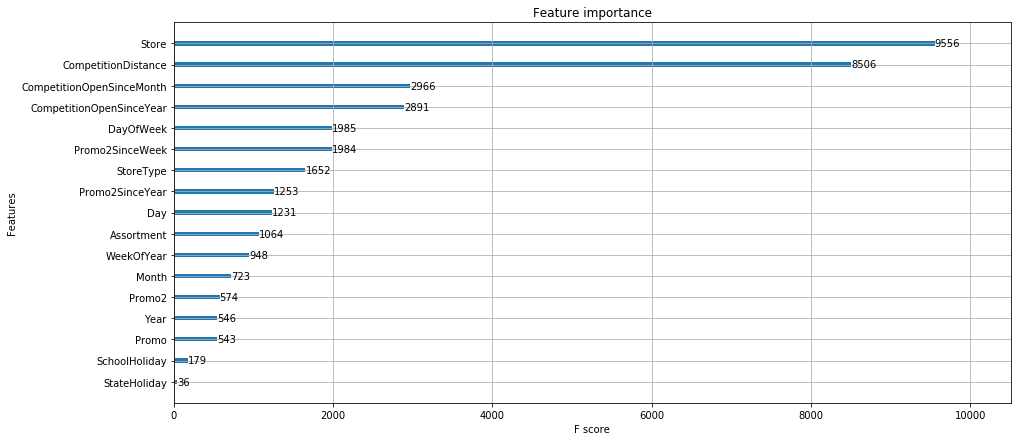

In [78]:
xgb.plot_importance(model_final)

In [80]:
test_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 21 columns):
Id                           41088 non-null int64
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Open                         41088 non-null float64
Promo                        41088 non-null int64
StateHoliday                 41088 non-null object
SchoolHoliday                41088 non-null int64
Year                         41088 non-null int64
Month                        41088 non-null int64
Day                          41088 non-null int64
WeekOfYear                   41088 non-null int64
StoreType                    41088 non-null int64
Assortment                   41088 non-null object
CompetitionDistance          41088 non-null float64
CompetitionOpenSinceMonth    41088 non-null float64
CompetitionOpenSinceYear     41088 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              41

In [83]:
# предскаказания на тренеровочных данных
unseen = xgb.DMatrix(test_store[predictors])
test_p = model_final.predict(unseen)

forecasts = pd.DataFrame({'Id': test['Id'], 
                          'Sales': np.exp(test_p)})

forecasts.head()

,Id,Sales
Date,,
2015-09-17,1,4893.395508
2015-09-17,2,5093.958496
2015-09-17,3,5578.815918
2015-09-17,4,6587.867188
2015-09-17,5,5428.808105


## 3. RandomForestRegressor

In [42]:
from sklearn.ensemble import RandomForestRegressor

In [50]:
test_store.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen
0,1,1,4,1.0,1,0,0,2015,9,17,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
1,857,1,3,1.0,1,0,0,2015,9,16,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
2,1713,1,2,1.0,1,0,0,2015,9,15,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
3,2569,1,1,1.0,1,0,0,2015,9,14,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
4,3425,1,7,0.0,0,0,0,2015,9,13,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.25


In [44]:
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,WeekOfYear,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
0,1,5,5263,555,1,1,0,1,2015,7,...,31,9.482883,3,1,1270.0,9.0,2008.0,0,0.0,0.0
1,1,4,5020,546,1,1,0,1,2015,7,...,31,9.194139,3,1,1270.0,9.0,2008.0,0,0.0,0.0
2,1,3,4782,523,1,1,0,1,2015,7,...,31,9.143403,3,1,1270.0,9.0,2008.0,0,0.0,0.0
3,1,2,5011,560,1,1,0,1,2015,7,...,31,8.948214,3,1,1270.0,9.0,2008.0,0,0.0,0.0
4,1,1,6102,612,1,1,0,1,2015,7,...,31,9.970588,3,1,1270.0,9.0,2008.0,0,0.0,0.0


In [100]:
mean_error = []
pred_y = []
test_y = []

for month in reversed(range(1,7)):


    tr = train_store[(train_store.Year==2015) & (train_store.Month==month+1)]
    ts = train_store[(train_store.Year==2015) & (train_store.Month==month)]
    
    y_train,y_test = np.log(tr.Sales).values, np.log(ts.Sales).values
    X_train, X_test = tr.drop(['Sales'], axis=1),ts.drop(['Sales'], axis=1)
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(X_train, y_train)
    
    p = mdl.predict(X_train)
    
    ln = min(len(y_test),len(p))
    error = rmspe(y_test[0:ln], p[0:ln])
    print('Week %d - Error %.5f' % (month, error))
    mean_error.append(error)
    .append(p)
    test_y.append(y_test)
    
print('Mean Error = %.5f' % np.mean(mean_error))

Week 6 - Error 0.06740
Week 5 - Error 0.06691
Week 4 - Error 0.06597
Week 3 - Error 0.06892
Week 2 - Error 0.06735
Week 1 - Error 0.06505
Mean Error = 0.06693


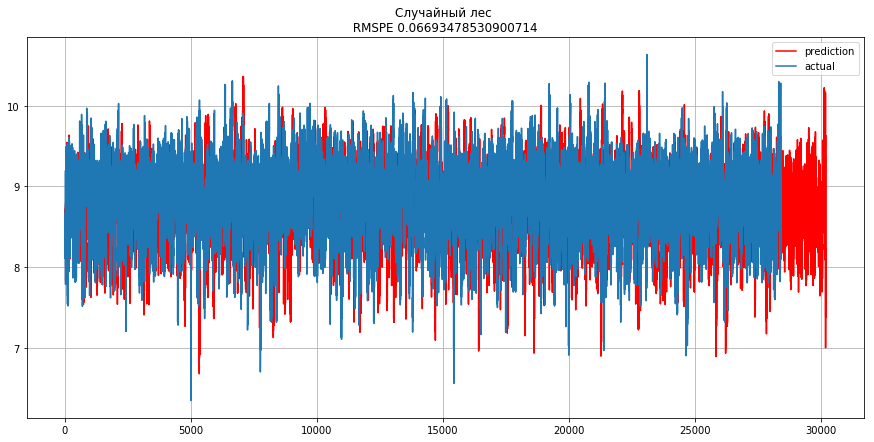

In [105]:
plt.figure(figsize=(15, 7))
plt.plot(pred_y[0], "r", label="prediction")
plt.plot(test_y[0], label="actual")
plt.legend(loc="best")
plt.title("Cлучайный лес \n RMSPE {} ".format(np.mean(mean_error),5))
plt.grid(True);

##  4.Анализ с Prophet 

In [1]:
# prophet by Facebook
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [4]:
#загружаем  данные
df = pd.read_csv('e:/DS/data/rossmann-store-sales/train.csv',  sep=',', index_col=['Date'], parse_dates=['Date'], dayfirst=True)
#test = pd.read_csv('e:/DS/data/rossmann-store-sales/test.csv',  sep=',', index_col=['Date'], parse_dates=['Date'], dayfirst=True)
#store = pd.read_csv('e:/DS/data/rossmann-store-sales/store.csv',  sep=',')


# удаляем закрытые и непродающие магазины
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Sales']]

# отсортируем в правильном порядке
sales = sales.sort_index(ascending = False)

sales['Date'] = pd.DatetimeIndex(sales.index)
sales.dtypes

E:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Sales             int64
Date     datetime64[ns]
dtype: object

In [5]:
# prophet  требуемт определенных имет признаков, переименуем
sales = sales.rename(columns = {'Date': 'ds','Sales': 'y'})
sales.head()


,y,ds
Date,,
2015-07-31,5263,2015-07-31
2015-07-30,5020,2015-07-30
2015-07-29,4782,2015-07-29
2015-07-28,5011,2015-07-28
2015-07-27,6102,2015-07-27


In [6]:
sales= sales.reset_index()
del sales['Date']
sales.head()

,y,ds
0,5263,2015-07-31
1,5020,2015-07-30
2,4782,2015-07-29
3,5011,2015-07-28
4,6102,2015-07-27


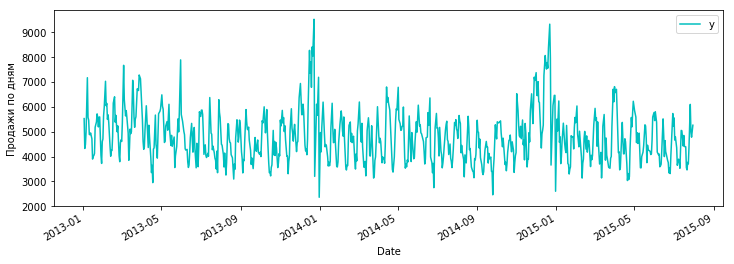

In [7]:
# ежедневные продажи
ax = sales.set_index('ds').plot(figsize = (12, 4), color = 'c')
ax.set_ylabel('Продажи по дням')
ax.set_xlabel('Date')
plt.show()

In [8]:
df['Date'] = pd.DatetimeIndex(df.index)


In [9]:
# выберем выходные
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [10]:
sales.head()

,y,ds
0,5263,2015-07-31
1,5020,2015-07-30
2,4782,2015-07-29
3,5011,2015-07-28
4,6102,2015-07-27


In [11]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 6*7)

print("Прогноз на неделю.")
future_dates.tail(7)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Прогноз на неделю.


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


In [12]:
# прогноз
forecast = my_model.predict(future_dates)

# прогнозируем последнюю неделю
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,4107.928508,2473.325791,5925.888379
817,2015-09-06,4081.629384,2510.283052,5681.130195
818,2015-09-07,4177.429012,2478.176729,5920.926111
819,2015-09-08,3680.085778,1926.432887,5345.091764
820,2015-09-09,3566.493508,1945.471518,5238.705675
821,2015-09-10,3478.576447,1856.802054,5101.557190
822,2015-09-11,3733.596403,2161.598211,5282.094165


In [13]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

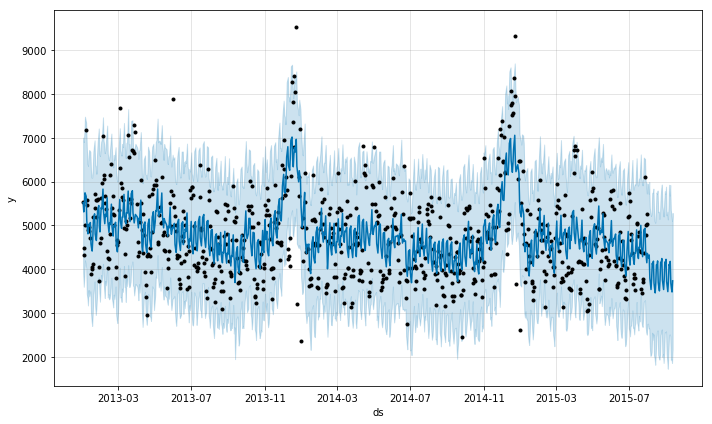

In [14]:
# visualizing predicions
my_model.plot(forecast);

In [ ]:
Видно, что модель хорошо приближает данные, а так же прогноз показывает падение продаж, что подтвержают следующие графики
компонент.

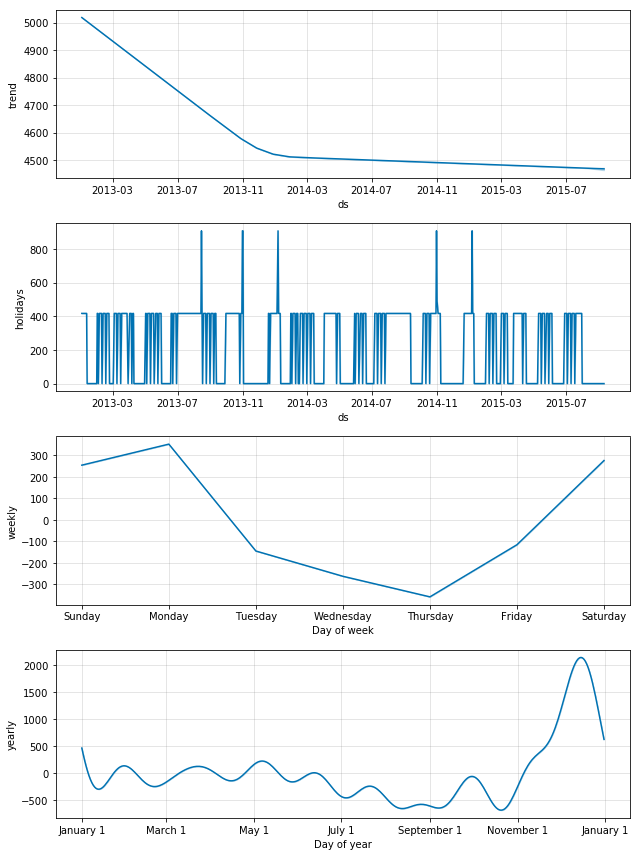

In [15]:
my_model.plot_components(forecast);

На графике тренда видно, что продажи в магазине 1 падают. Это падение показывает и прогноз модели на первом графике.
На недельном графике видно, что есть недельная сезонность,пик продаж приходится на понедельник и выходные, а середине недели 
продажи падают.
На годовом графике видно, что на новогодние праздники и Рождество, приходится пик и он очень ярко выражен.

In [25]:
fc.head()


,ds,yhat
0,2013-01-02,5517.005295
1,2013-01-03,5306.851587
2,2013-01-04,5444.806216
3,2013-01-05,5742.423808
4,2013-01-07,5662.902750


In [26]:
sales.head()

,y,ds
780,5530,2013-01-02
779,4327,2013-01-03
778,4486,2013-01-04
777,4997,2013-01-05
776,7176,2013-01-07


In [24]:
sales = sales.sort_values('ds', ascending = True)
fc = fc.sort_values('ds', ascending = True)

In [31]:
prophet__error =  rmspe(sales['y'], fc['yhat'])
print("Prophet RMSPE {} ".format(np.mean(prophet__error),5))

Prophet RMSPE 0.26613421084738603 


In [ ]:
При сравнении модели по метрике rmspe, случайный лес показывает лучшие результаты